**Note: time unit conversions**

- 1ns = 1e-6 ms = 0.000001 millisecond
- 1 millisecond (ms) = 0.001 seconds
- 1 microsecond = 0.001 millseconds
- alternatively 
    - 10e-9 = nanosecond (ns)
    - 10e-6 = microsecond (mu s)
    - 10e-3 = millisecond (ms)


**Note: interpreting timings**

- `user` + `sys` tell us whow much actual CPU time the process has used. `user` is the time taken on the CPU and `sys` is additional time taken such as allocating memory, which the code cannot do from "user" mode.
- I think wall time is `real`, and could be confounded by other processes

## Computing $\pi$

We now start with the first paralellization tasks. We will
- see how a python application can be parallelized
- discuss **data parallelism** and **task parallelism**


We use the example of computing $\pi$ because it is a simple example that still takes some time to compute, so perfect for our instructional purposes.

The way this works is with **Monte-Carlo** methods--this means approximating exact results with random numbers and simulation.



### The geometry behind 
<mark> add figure from online material </mark>
- [link to online material](https://esciencecenter-digital-skills.github.io/parallel-python-workbench/instructor/computing-pi.html)
- assume a unit radius
- then the surface of the square is `4r^2`
- the surface of the circle is `pi r^2`
- if we can compute the surfaces, we can call them `M` for the circle and `N` for the square
- then we have `M / N = pi r^2 / 4 r^2`
- solving for `pi` we get `pi = 4 M / N`

How do we get `M` and `N`?

<mark> Exercise: implement the algorithm (time?) </mark>
- using only standard python and the `random.uniform` function

In [169]:
import random 
import math 

def calc_pi(N):
    "Compute pi using N random samples"
    M = 0 
    for i in range(N):
        # Simulate random coordinates
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1: # don't need sqrt b/c 1**2 = 1
            M += 1

    return 4*M/N

In [170]:
time_forloop = %timeit -o calc_pi(10**6)


546 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Before starting to parallelize, we should make the inner function (the for loop) as efficient as possible. We discuss two options
1. vectorization with `numpy` 
2. native code generation with `numba`

Vectorization works by applying the computation over an array of numbers, instead of each number individually.

What does `numba` do? 
- when we execute python code, the line is *interpreted* and directly performed. the speed of this depends on how the programming language is designed *(interpretation)*
- an alternative is *compiled* code, where we write in some language and the translate the code to machine code. Only after this we execute the program. *(ahead-of-time compilation)*
- numba sits in between the two and performs *just-in-time compilation*. It generates optimized machine code---that is faster than python code---, at runtime. This means that our code is compiled to machine code as we define the function. 
    - this is faster than python code but has additional overhead from compiling


#### Numpy

In [171]:
# can use this to show how to get to the function below
import numpy as np 
np.random.uniform(-1, 1, (1, 1))
points = np.random.uniform(-1, 1, (2, 100))
(points**2).sum(axis=0)
(points**2).sum(axis=0) < 1
np.count_nonzero((points**2).sum(axis=0) < 1)

M = np.count_nonzero((points**2).sum(axis=0) < 1)

4 * M / 100

3.28

In [172]:
def calc_pi_numpy(N):
    "Compute pi using N samples with numpy"
    points = np.random.uniform(-1, 1, (2, N))
    # M = np.count_nonzero((points**2).sum(axis=0) < 1)
    M = np.count_nonzero((points**2).sum(axis=0) < 1)
    return 4 * M / N


In [173]:
calc_pi_numpy(10**6)

3.144092

In [174]:
time_numpy = %timeit -o calc_pi_numpy(10**6)


16.9 ms ± 588 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [175]:
speedup = time_forloop.average / time_numpy.average
print(f"Using numpy is {speedup:.2f} times faster than using the for loop")

Using numpy is 32.29 times faster than using the for loop


This is a *vectorized* version of the algorithm: It demonstrates **data parallelism** where a single operation is applied over a collection of data. 

This contrasts to **task parallelism** where different independent procedures are applied in parallel. Example: cutting vegetables while simmering the split peas.

<mark>Discussion: Is this all better?</mark>

What are the downside of the vectorized implementation, and of data parallelism in general?
- it uses more memory
- it is perhaps less intuitive 
- it is more monolithic and it cannot easily be broken up into parts -- in contrast to the example below.

<mark> Challenge: Daskify </mark>

Write `calc_pi_dask` to make the numpy version parallel. Compare speed and memory performance with the numpy version. Remember that dask.array mimics the numpy API.

In [176]:
#can use this to illustrate how get to to the function below
import dask.array as da
points = da.random.uniform(-1, 1, (2, 100))
(points**2).sum(axis=0).compute() < 1
work = da.count_nonzero((points**2).sum(axis=0) < 1)
work.compute()

80

In [177]:
def calc_pi_dask(N):
    "Compute pi using N samples with dask"
    points = da.random.uniform(-1, 1, (2, N))
    work = da.count_nonzero((points**2).sum(axis=0) < 1)
    
    # using the physical number of cores, as we found out in previous episode
    M = work.compute(num_workers=4) 
    return 4 * M / N


In [178]:
calc_pi_dask(10**6)

3.141164

In [179]:
time_dask = %timeit -o calc_pi_dask(10**6)


24.7 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [180]:
speedup = time_forloop.average / time_dask.average
print(f"Using dask is {speedup:.2f} times faster than using the for loop")

Using dask is 22.10 times faster than using the for loop


**Compare memory and performance**

In [181]:
from memory_profiler import memory_usage
import matplotlib.pyplot as plt 

In [182]:
# Little wrappers to make life easy
N = 10**8
def pi_with_numpy():
    return calc_pi_numpy(N)

def pi_with_dask():
    return calc_pi_dask(N)

In [183]:
memory_numpy = memory_usage(pi_with_numpy, interval=0.01)
time_numpy = %timeit -o pi_with_numpy()

1.79 s ± 22.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [184]:
memory_dask = memory_usage(pi_with_dask, interval=0.01)
time_dask = %timeit -o pi_with_dask()

763 ms ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [185]:
speedup = time_numpy.average / time_dask.average
print(f"Using dask is {speedup:.2f} times faster than using numpy")

Using dask is 2.35 times faster than using numpy


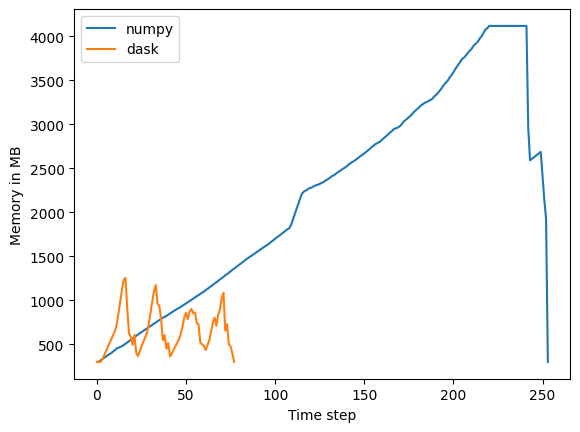

In [186]:
plt.plot(memory_numpy, label="numpy")
plt.plot(memory_dask, label="dask")
plt.xlabel("Time step")
plt.ylabel("Memory in MB")
plt.legend()
plt.show()

### Using numba to accelerate python code

numba makes it easy for us to build accelerated functions. We can call the decorator `numba.jit`. What does it do? -- It sends the function, to which we apply the decorator, to machine code when we execute the cell 

In [187]:
import numba 

@numba.jit 
def sum_range_numba(a):
    "Compute the sum of the numbers in the range [0, a)"
    x = 0 
    for i in range(a):
        x += 1 
    return x 

Let's time three different versions of this.

In [188]:
## Naive python iterators
time_naive = %timeit -o sum(range(10**7))

136 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [189]:
# numpy 
time_numpy = %timeit -o np.arange(10**7).sum()

14.8 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [190]:
# numba 
time_numba = %timeit -o sum_range_numba(10**7)
# sometimes a warning appears "[could be that ..] intermediate result is being cached". 
# re-running usually helps

135 ns ± 3.05 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [191]:
speedup = time_numpy.average / time_numba.average
print(f"Using numba is {speedup:.2f} times faster than using numpy")

Using numba is 109510.98 times faster than using numpy


So, numba is 100k times faster (?)

(14.7.5 * 10e-3) / (128 * 10e-9) = (17.5 * 10e-3) / (12.8 * 10e-8) = 10e-5

`numba` JIT does not work on every python or numpy feature, but a function is a good candidate if written with a python for-loop over a large range of values, as with `sum_range_numba()`.


**Note on just-in-time compilation**
- there may be little or no speed-up when function is called the first time 
- similarly, when using `timeit` you may get the following message
    - `The slowest run took 14.83 times longer than the fastest. This could mean that an intermediate result is being cached.`
- reason: on the first call, the JIT compiler needs to compile the function. on subsequent runs, the function is reused
- **the same function can only be reused if it is called with the same argument types (int, float, etc)**

In [192]:
%time sum_range_numba(10**7)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.15 µs


10000000

In [193]:
%time sum_range_numba(10.**7)

CPU times: user 130 ms, sys: 7.73 ms, total: 138 ms
Wall time: 137 ms


10000000

In [194]:
%time sum_range_numba(10.**7)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11.7 µs


10000000

<mark>Challenge: numbify `calc_pi`</mark>

Create a numba version of `calc_pi`. Time it.

In [195]:
# note we're moving back to a function that looks similar to the original function
@numba.jit
def calc_pi_numba(N):
    "Compute pi using N samples with numba"
    M = 0 
    for i in range(N):
        # Simulate random coordinates
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1.0: # don't need sqrt b/c 1**2 = 1
            M += 1

    return 4*M/N

In [196]:
calc_pi_numba(10**7)

3.142

In [197]:
time_numba = %timeit -o calc_pi_numba(10**6)


6.89 ms ± 67.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [199]:
speedup = time_dask.average / time_numba.average
print(f"Using numba is {speedup:.2f} times faster than using dask")

Using numba is 110.70 times faster than using dask


- also: random number generator changes

## Conclusion
- measuring - knowing: always profile your code to see which parallelization method works best 
- numba often outperforms other methods, but it is not always possible to rewrite code so that one can use numba with it